<a href="https://colab.research.google.com/github/zierenberg/machine_learning_muca/blob/master/simple_doubleWell_from_2019_noe_et_al_fig2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/zierenberg/machine_learning_muca.git

Cloning into 'machine_learning_muca'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 72 (delta 14), reused 40 (delta 1), pack-reused 0
Unpacking objects: 100% (72/72), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.append("machine_learning_muca/2019_noe_deep_boltzmann_tfv2")

from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
#from deep_boltzmann.sampling import GaussianPriorMCMC
#from deep_boltzmann.networks.plot import test_xz_projection
#from deep_boltzmann.util import count_transitions
#from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
def test_sample(network, temperature=1.0, nsample=100000, plot=True):
    if nsample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=nsample)
    else:
        sample_x = []
        for i in range(int(nsample/100000)):
            _, sample_x_, _, _, _ = network.sample(temperature=temperature, nsample=nsample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

Double well
---

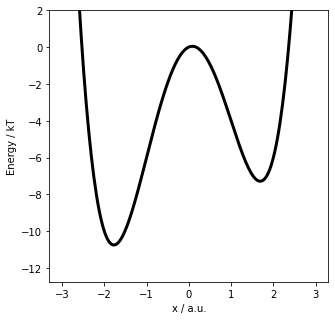

In [7]:
params = DoubleWell.params_default.copy()
params['dim'] =2
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();

In [8]:
def plot_potential(cbar=True, orientation='vertical', figsize=(4, 5.5)):
    # 2D potential
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-7, 7, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = double_well.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.5, 7.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            #cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
    plt.xticks([-2, 0, 2])
    plt.yticks([-5, 0, 5])
    plt.xlabel('$x_1$', labelpad=0)
    plt.ylabel('$x_2$', labelpad=-10)

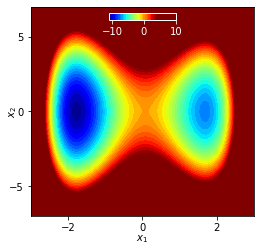

In [9]:
plot_potential(orientation='horizontal')

Network properties 
--------------------

Standard training without samples
-------

In [49]:
network_NICER_KL = invnet(double_well.dim, 'NNNNS', double_well, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<NNNN>S
< 2 0 0
N 1 1 0
N 1 1 0
N 1 1 0
N 1 1 0
> 1 1 0
S 2 0 0
tracking <tf.Variable 'log_scale:0' shape=(1, 2) dtype=float32, numpy=array([[0., 0.]], dtype=float32)> log_scaling_factors
tracking <tf.Variable 'log_scale:0' shape=(1, 2) dtype=float32, numpy=array([[0., 0.]], dtype=float32)> log_scaling_factors


In [51]:
def train_simple(self, optimizer=None, lr=0.001, epochs=2000, batch_size=1024,
                 verbose=1, clipnorm=None, temperature=1.0):   
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.adam(lr=lr)
            else:
                optimizer = keras.optimizers.adam(lr=lr, clipnorm=clipnorm)

        def loss_KL(y_true, y_pred):       
            x = self.output_x        
            # compute energy
            E = self.energy_model.energy_tf(x) / temperature
            return self.log_det_Jzx[:, 0] + E

        self.Tzx.compile(optimizer, loss=loss_KL)

        dummy_output = np.zeros((batch_size, self.dim))
        train_loss = []
        train_x = []
        for e in range(epochs):
            # train in batches (simple normal distribution)       
            z = np.random.randn(batch_size, self.dim)
            x = self.transform_zx(z)
            train_x.append(x)
            # this should work in tf2 with None 
            train_loss_batch = self.Tzx.train_on_batch(x=z, y=dummy_output)
            train_loss.append(train_loss_batch)
        train_loss = np.array(train_loss)
        return train_loss, train_x

In [52]:
epochs = 100
batchsize = 5000

In [53]:
T1_0_train_loss, T1_0_train_x = train_simple(network_NICER_KL, epochs=epochs, batch_size=batchsize, temperature=1)

In [54]:
T0_1_train_loss, T0_1_train_x = train_simple(network_NICER_KL, epochs=epochs, batch_size=batchsize, temperature=0.1)

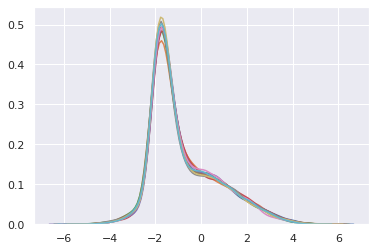

In [56]:
import seaborn as sns
sns.set(color_codes=True)
for x in T1_0_train_x[::10]:
  sns.distplot(x, hist=False);

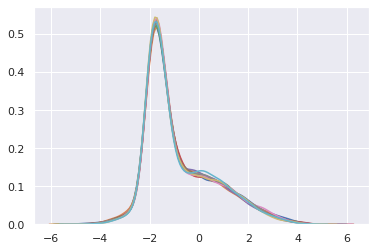

In [57]:
sns.set(color_codes=True)
for x in T0_1_train_x[::10]:
  sns.distplot(x, hist=False);
